<a href="https://colab.research.google.com/github/kk20krishna/X-ray-image-Classification/blob/main/X_ray_image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Image Classification using Transfer Learning

## Introduction

**Background:**

- Pleural effusion is the abnormal accumulation of fluid in the pleural space, which is the area between the lungs and the chest wall.
- This excess fluid can be caused by a variety of factors, including heart failure, pneumonia, cancer, and kidney disease.
- Symptoms of pleural effusion can include shortness of breath, chest pain, and coughing, and treatment typically involves draining the fluid and addressing the underlying cause.

Chest X-rays are a widely used imaging technique for diagnosing various pulmonary diseases. The detection of pleural effusion, the abnormal accumulation of fluid in the pleural space surrounding the lungs, is crucial for timely medical intervention. Manual interpretation of chest X-rays can be time-consuming and prone to inter-observer variability. Therefore, automated methods for effusion detection are highly desirable.

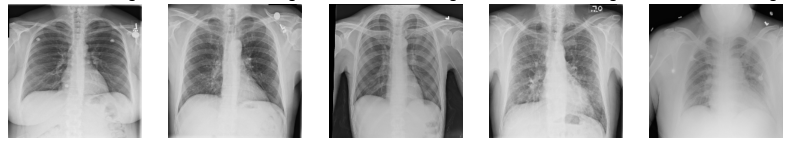

**Objective:**

This notebook aims to develop an image classification model capable of accurately identifying pleural effusion in chest X-ray images. We leverage the power of transfer learning, a technique that utilizes pre-trained models to accelerate the development of new models for specific tasks.

**Dataset:**

We utilize the CXR dataset, a publicly available collection of chest X-ray images labeled with the presence or absence of pleural effusion. The dataset consists of 1107 images, with images belonging to 'effusion' and 'nofinding' classes.
Dataset - https://www.kaggle.com/datasets/kk20krishna/cxr-data

## Housekeeping

In [ ]:
#!pip install augmentor

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import kagglehub
import Augmentor
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Rescaling, Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

## Data Loading and Preprocessing

### Downloading the Dataset
The dataset is downloaded from Kaggle using the `kagglehub` library.

In [ ]:
# delete folder
!rm -rf /root/.cache/kagglehub/datasets/kk20krishna/cxr-data/versions/1


In [ ]:
# Download latest version
path = kagglehub.dataset_download("kk20krishna/cxr-data")
#path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

100%|██████████| 414M/414M [00:01<00:00, 227MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kk20krishna/cxr-data/versions/1


### Exploring the Dataset
The dataset contents are listed and sample images are displayed using `matplotlib`.

In [ ]:
# List the contents of the dataset folder
dataset_files = os.listdir(path)
print("Files in dataset folder:", dataset_files)

Files in dataset folder: ['effusion', 'nofinding']


In [ ]:
dataset = keras.utils.image_dataset_from_directory(path)

Found 1107 files belonging to 2 classes.


(32, 256, 256, 3) (32,)


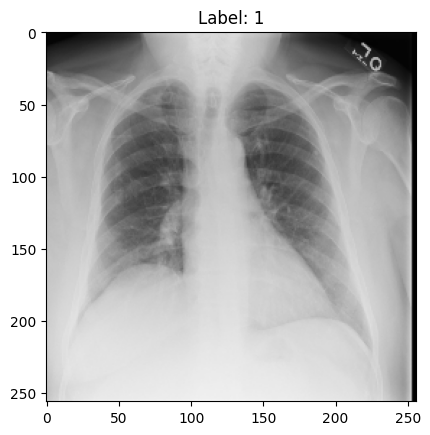

In [ ]:
# Get the images from the dataset
dataset.batch(1)
for image, label in dataset.take(1):
  print(image.shape, label.shape)
  first_image = image[0].numpy()
  first_label = label[0].numpy()


  plt.imshow(first_image.astype('uint8')) # Ensure correct display
  plt.title(f"Label: {first_label}")
  plt.show()

In [ ]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(path,
                                                   label_mode='categorical',
                                                   validation_split=0.2,
                                                   subset="both",
                                                   image_size=(224, 224),
                                                   seed=44,)

Found 1107 files belonging to 2 classes.
Using 886 files for training.
Using 221 files for validation.


In [ ]:
train_dataset.class_names

['effusion', 'nofinding']

### Data Augmentation
     Augmentation is applied to the 'effusion' class images using the `Augmentor` library.

In [ ]:
p = Augmentor.Pipeline(os.path.join(path,'effusion'))

# Add operations to the pipeline
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#p.zoom(probability=0.5, min_factor=1.1, max_factor=1.2)
# Add other operations as needed (e.g., shear, brightness, contrast)

# Execute the pipeline (generate augmented images)
p.sample(200) # Generate 100 augmented images per class

Initialised with 107 image(s) found.
Output directory set to /root/.cache/kagglehub/datasets/kk20krishna/cxr-data/versions/1/effusion/output.

Processing <PIL.Image.Image image mode=L size=1024x1024 at 0x7B7D41A1A910>: 100%|██████████| 200/200 [00:38<00:00,  5.22 Samples/s]


In [ ]:
os.listdir(path)

['effusion', 'nofinding']

In [ ]:
len(os.listdir(os.path.join(path,'nofinding'))), len(os.listdir(os.path.join(path,'effusion'))), len(os.listdir(os.path.join(path,'effusion','output')))

(1000, 108, 200)

### Dataset Splitting
     The dataset is split into training and validation sets using `keras.utils.image_dataset_from_directory` with a validation split of 0.2.

In [ ]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(path,
                                                   label_mode='categorical',
                                                   validation_split=0.2,
                                                   subset="both",
                                                   image_size=(224, 224),
                                                   seed=44,)

Found 1307 files belonging to 2 classes.
Using 1046 files for training.
Using 261 files for validation.


In [ ]:
train_dataset.class_names

['effusion', 'nofinding']

## Model Building and Training

### Model Architecture
The ResNet50V2 model pre-trained on ImageNet is used as the base model. The top classification layer is replaced with new layers for binary classification.

The model is compiled using the 'adam' optimizer, 'categorical_crossentropy' loss function, and metrics including 'accuracy', 'AUC', 'precision', and 'recall'.

In [ ]:
# Define input layer with rescaling (normalization)
inputs = Input(shape=(224, 224, 3))
x = Rescaling(1./255.)(inputs)  # Rescale pixel values to [0,1]

# Load the pre-trained ResNet50V2 model without the top classification layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=x)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Use Global Average Pooling instead of Flatten (reduces parameters)
x = GlobalAveragePooling2D()(base_model.output)

# Reduce number of Dense layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Final output layer for binary classification
predictions = Dense(2, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (you can adjust the optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'precision', 'recall'])

# Print the model summary to see the architecture
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ rescaling_1            │ (None, 224, 224, 3)  │            0 │ input_layer_1[0][0] │    -    │
│ (Rescaling)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_pad              │ (None, 230, 230, 3)  │            0 │ rescaling_1[0][0]   │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_conv (Conv2D)    │ (None, 112, 112, 64) │        9,472 │ conv1_pad[0][0]     │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pad              │ (None, 114, 114, 64) │            0 │ conv1_conv[0][0]    │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pool             │ (None, 56, 56, 64)   │            0 │ pool1_pad[0][0]     │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_preact_bn │ (None, 56, 56, 64)   │          256 │ pool1_pool[0][0]    │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_preact_r… │ (None, 56, 56, 64)   │            0 │ conv2_block1_preac… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_conv    │ (None, 56, 56, 64)   │        4,096 │ conv2_block1_preac… │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_bn      │ (None, 56, 56, 64)   │          256 │ conv2_block1_1_con… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_relu    │ (None, 56, 56, 64)   │            0 │ conv2_block1_1_bn[… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_pad     │ (None, 58, 58, 64)   │            0 │ conv2_block1_1_rel… │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_conv    │ (None, 56, 56, 64)   │       36,864 │ conv2_block1_2_pad… │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_bn    

 Total params: 24,679,810 (94.15 MB)

 Trainable params: 1,115,010 (4.25 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Model Training
The model is trained for 50 epochs using the training dataset and evaluated on the validation dataset.

In [ ]:
model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 898ms/step - AUC: 0.7952 - accuracy: 0.7338 - loss: 0.7151 - precision: 0.7338 - recall: 0.7338 - val_AUC: 0.9232 - val_accuracy: 0.8276 - val_loss: 0.3655 - val_precision: 0.8276 - val_recall: 0.8276
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 536ms/step - AUC: 0.8638 - accuracy: 0.7795 - loss: 0.5021 - precision: 0.7795 - recall: 0.7795 - val_AUC: 0.9194 - val_accuracy: 0.8621 - val_loss: 0.3977 - val_precision: 0.8621 - val_recall: 0.8621
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 517ms/step - AUC: 0.8987 - accuracy: 0.8110 - loss: 0.4019 - precision: 0.8110 - recall: 0.8110 - val_AUC: 0.9326 - val_accuracy: 0.8889 - val_loss: 0.3328 - val_precision: 0.8889 - val_recall: 0.8889
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 577ms/step - AUC: 0.9332 - accuracy: 0.8556 - loss: 0.3419 - precision: 0.8556 - recall: 0.8556 - val_AUC: 0.9391 - val_accuracy: 0.8812 - val_loss: 0.3115 - val_precision: 0.8812 - val_recall: 0.8812
Epoch 5/50
33/33 ━━━━━━━━━━━

## Model Evaluation

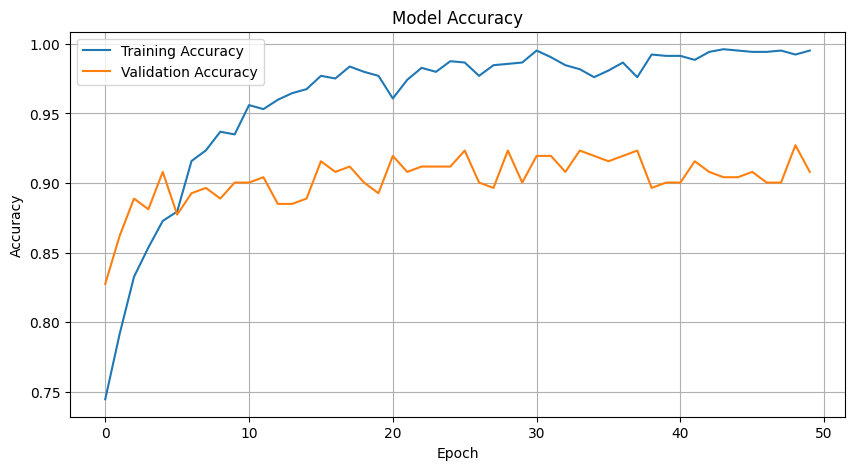

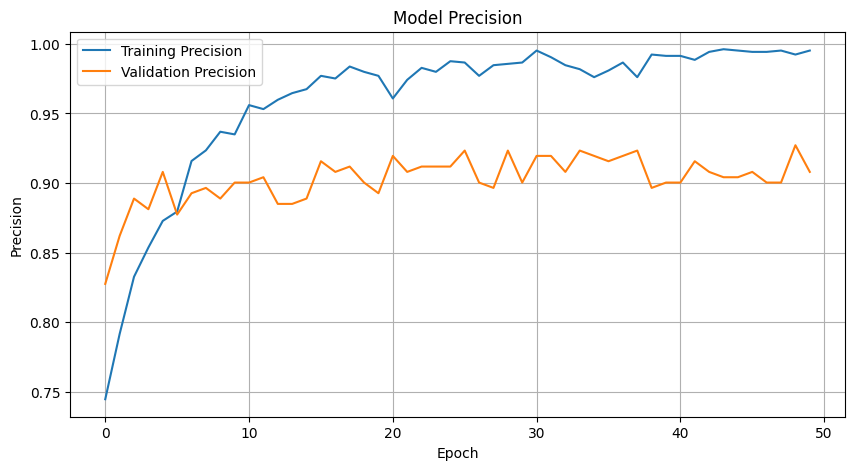

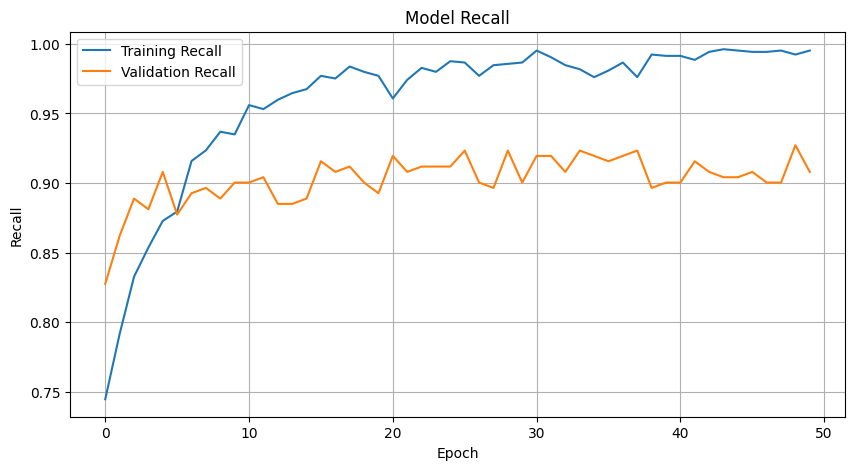

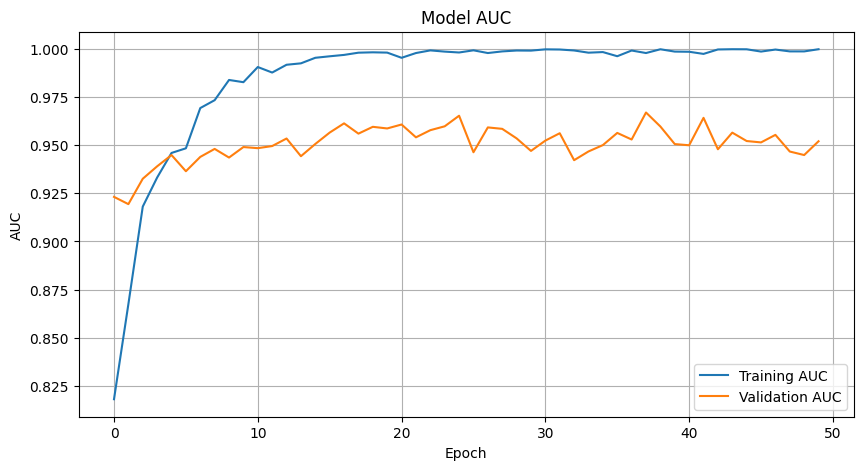

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(model.history.history['precision'], label='Training Precision')
plt.plot(model.history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(model.history.history['recall'], label='Training Recall')
plt.plot(model.history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(model.history.history['AUC'], label='Training AUC')
plt.plot(model.history.history['val_AUC'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix
     A confusion matrix is plotted to show the model's performance in classifying the two classes.

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step


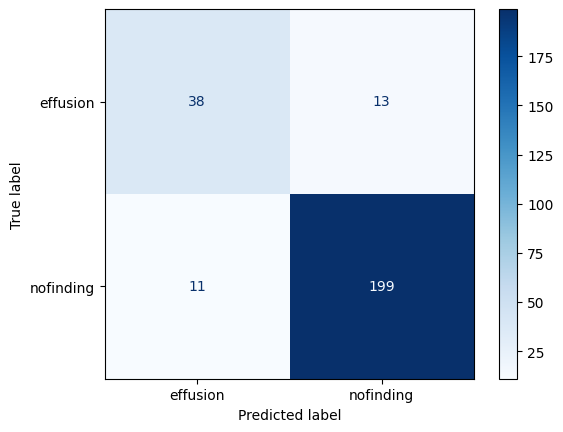

In [ ]:
predictions = model.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class labels
true_labels = np.concatenate([y for x, y in val_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)


cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Prediction Visualizations
Predictions are made on a sample of images from the validation dataset and visualized along with the true labels.

class_names:  ['effusion', 'nofinding']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


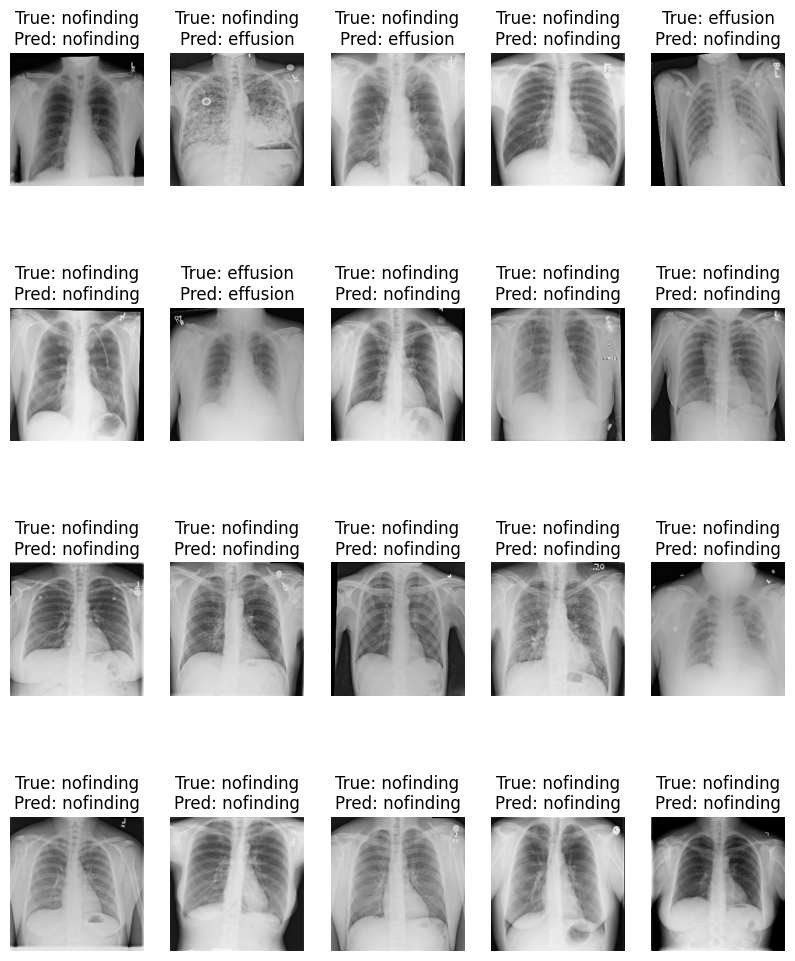

In [ ]:
# Define class names from dataset
class_names = val_dataset.class_names  # Get class labels from dataset
print("class_names: ", class_names)

# Take 10 images from val_dataset
num_images = 20
for images, labels in val_dataset.take(1):  # Take one batch
    images = images[:num_images]  # Select first 10 images
    labels = labels[:num_images]  # Corresponding labels
    # Make predictions
    predictions = model.predict(images)  # Get predicted probabilities
    predicted_classes = np.argmax(predictions, axis=1)  # Convert to class index
    true_classes = np.argmax(labels.numpy(), axis=1)  # Convert one-hot labels to index

    # Display images, true labels, and predicted labels
    plt.figure(figsize=(10, 16))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)  # Arrange in 2 rows of 5 images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")  # Hide axes

    plt.show()

class_names:  ['effusion', 'nofinding']
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


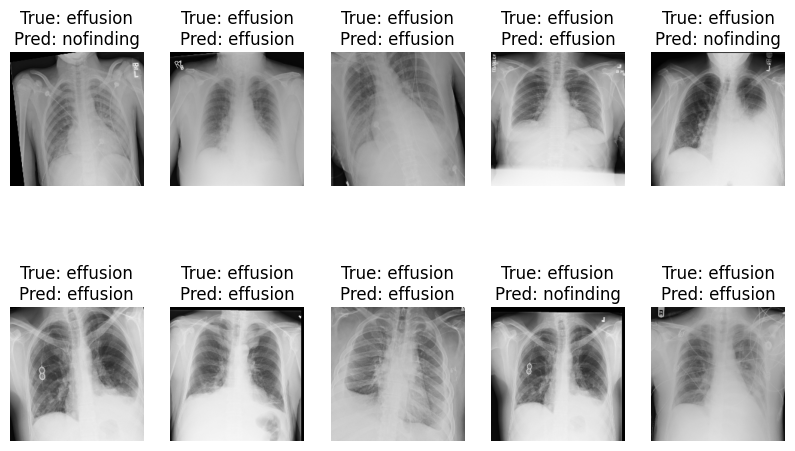

In [ ]:
# Define class names from dataset
class_names = val_dataset.class_names  # Get class labels from dataset
print("class_names: ", class_names)

# Take 10 images of class 0 from val_dataset
num_images = 10
class_index_to_select = 0 # Index for class 0
selected_images = []
selected_labels = []
selected_predictions = []


for images, labels in val_dataset:
  true_classes = np.argmax(labels.numpy(), axis=1)
  image_indices = np.where(true_classes == class_index_to_select)[0]

  if len(image_indices) > 0 :
    # Convert image_indices to a list of integers for slicing
    image_indices_list = image_indices[:min(num_images, len(image_indices))].tolist()

    # Use tf.gather to select images based on the indices
    selected_images.extend(tf.gather(images, image_indices_list))
    selected_labels.extend(tf.gather(labels, image_indices_list))

  if len(selected_images) >= num_images:
    break


# Make predictions on the selected images
predictions = model.predict(np.array(selected_images))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(np.array(selected_labels), axis=1)

# Display images, true labels, and predicted labels
plt.figure(figsize=(10, 16))
for i in range(min(num_images, len(selected_images))):
    plt.subplot(5, 5, i + 1)  # Arrange in 2 rows of 5 images
    plt.imshow(selected_images[i].numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis("off")  # Hide axes

plt.show()

## Saving the Model


**The trained model achieved AUC: 0.9521, Accuracy: 0.9080, Precision: 0.9080 and Recall: 0.9080 on the validation dataset,** indicating the model's performance in correctly classifying images into effusion and nofinding categories. Visualization of predictions on sample images further demonstrated the model's ability to accurately identify pleural effusion.

In [ ]:
model.save('x_ray_model.keras')

The trained model is saved to a file named 'x_ray_model.keras'.